In [1]:
import numpy as np
import os
import sys
import pandas as pd
import seaborn as sns

import pylab as pl
import h5py

import tensorflow as tf
from tensorflow.keras import mixed_precision

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ['CUDA_VISIBLE_DEVICES']="0" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


from sklearn.metrics import confusion_matrix

base_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3'
os.chdir(base_dir)
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.Modeling.DynamicModels import DynamicModels
from Classes.Modeling.TrainSingleModel import TrainSingleModel
from Classes.DataProcessing.RamLoader import RamLoader
from Classes.DataProcessing.ts_RamGenerator import modified_data_generator
import json

import gc

import datetime
import re
from livelossplot import PlotLossesKeras
from GlobalUtils import GlobalUtils
from Classes.Modeling.CustomCallback import CustomCallback
from tensorflow.keras.callbacks import EarlyStopping
utils = GlobalUtils()

from tensorflow.keras.utils import GeneratorEnqueuer






import sys


helper = HelperFunctions()

tf.config.optimizer.set_jit(True)
mixed_precision.set_global_policy('mixed_float16')

load_args = {
    'earth_explo_only' : True,
    'noise_earth_only' : False,
    'noise_not_noise' : False,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 0.25,
    'balance_non_train_set' : False,
    'use_true_test_set' : False,
    'even_balance' : True
}
loadData = LoadData(**load_args)
train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)





1 Physical GPUs, 1 Logical GPUs

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3090, compute capability 8.6
2 2
Mapping train redundancy: : [--------------------------------------->] 100 %

Mapping validation redundancy: : [--------------------------------------->] 100 %

Mapping test redundancy: : [--------------------------------------->] 100 %



Loaded explosion and earthquake dataset:
Evenly balanced among classes in the train set.
Distribution (Label: (counts, proportion)) of
Train ds:
earthquake: (20507, 0.4987)  |  explosion: (20616, 0.5013)  
Val ds:
earthquake: (255, 0.0762)  |  explosion: (3092, 0.9238)  
Test ds:
earthquake: (176, 0.0789)  |  explosion: (2055, 0.9211)  


In [2]:
model_type = "CNN_grow_double"
is_lstm = True
num_channels = 3    

use_time_augmentor = True
scaler_name = "normalize"
use_noise_augmentor = True
filter_name = None
band_min = 2.0
band_max = 4.0
highpass_freq = 0.075


shutdown = False

num_classes = len(list(set(loadData.label_dict.values())))



ramLoader = RamLoader(loadData, 
                      handler, 
                      use_time_augmentor = use_time_augmentor, 
                      use_noise_augmentor = use_noise_augmentor, 
                      scaler_name = scaler_name,
                      filter_name = filter_name, 
                      band_min = band_min,
                      band_max = band_max,
                      highpass_freq = highpass_freq, 
                      load_test_set = True, 
                      meier_load = False)

x_train, y_train, x_val, y_val, x_test, y_test, noiseAug = ramLoader.load_to_ram()

Fitting noise set time augmentor: [--------------------------------------->] 100 %

Fit process completed after 73.49886393547058 seconds. Total datapoints fitted: 21199.
Average time per datapoint: 0.003467091086158337


Fitting train time augmentor: [--------------------------------------->] 100 %

Fit process completed after 188.56127309799194 seconds. Total datapoints fitted: 41123.
Average time per datapoint: 0.004585299542786079


Fitting validation time augmentor: [--------------------------------------->] 100 %

Fit process completed after 28.16930389404297 seconds. Total datapoints fitted: 3347.
Average time per datapoint: 0.008416284402164019


Fitting test time augmentor: [--------------------------------------->] 100 %

Fit process completed after 18.936338663101196 seconds. Total datapoints fitted: 2231.
Average time per datapoint: 0.008487825487719048


Stage one loading training set, timeAug: [--------------------------------------->] 100 %

Stage one loading validation 

In [3]:
params = {     'batch_size': 256,
                    'cnn_activation': 'relu',
                    'dense_activation': 'relu',
                    'dropout_T_bn_F': True,
                    'dropout_rate': 0.001,
                    'epochs': 10,
                    'filter_size': 74,
                    'first_dense_units': 254,
                    'growth_sequence': [1, 4, 8, 8, 8],
                    'l1_r': 0.0,
                    'l2_r': 0.001,
                    'learning_rate': 0.001,
                    'num_filters': 78,
                    'num_layers': 3,
                    'optimizer': 'adam',
                    'output_layer_activation': 'sigmoid',
                    'padding': 'same',
                    'second_dense_units': 234,
                    'use_layerwise_dropout_batchnorm': True}

use_tensorboard = True
use_liveplots = False
use_custom_callback = True
use_early_stopping = True
start_from_scratch = True
use_reduced_lr = False
log_data = False
beta = 3

def clear_tensorboard_dir():
        import os
        import shutil
        path = f"{base_dir}/Tensorboard_dir/fit"
        files = os.listdir(path)
        print(files)
        for f in files:
            shutil.rmtree(os.path.join(path,f))
if use_tensorboard:
    clear_tensorboard_dir()


modelTrain = TrainSingleModel(x_train, y_train, x_val, y_val, x_test, y_test, noiseAug, helper,
                              loadData, model_type, num_channels, use_tensorboard, use_liveplots,
                              use_custom_callback, use_early_stopping, use_reduced_lr, ramLoader,
                              log_data = log_data, results_df = None, results_file_name = None, index = None, 
                              start_from_scratch = start_from_scratch, beta = beta)

model, _ = modelTrain.run(16, 15, evaluate_train = True, evaluate_val = True, evaluate_test = True, meier_mode = False, **params)

['20210420-143001']
[   {'model_type': 'CNN_grow_double'},
    {   'batch_size': 256,
        'cnn_activation': 'relu',
        'dense_activation': 'relu',
        'dropout_T_bn_F': True,
        'dropout_rate': 0.001,
        'epochs': 10,
        'filter_size': 74,
        'first_dense_units': 254,
        'growth_sequence': [1, 4, 8],
        'l1_r': 0.0,
        'l2_r': 0.001,
        'learning_rate': 0.001,
        'num_filters': 78,
        'num_layers': 3,
        'optimizer': 'adam',
        'output_layer_activation': 'sigmoid',
        'padding': 'same',
        'second_dense_units': 234,
        'use_layerwise_dropout_batchnorm': True}]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6000, 3)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 6000, 78)          17394     


In [38]:
from Classes.DataProcessing.ts_RamGenerator import data_generator
from tensorflow.keras.utils import GeneratorEnqueuer

steps = helper.get_steps_per_epoch(x_val, params["batch_size"])
val_enq = GeneratorEnqueuer(data_generator(x_val, y_val, params["batch_size"], None, num_channels = num_channels, is_lstm  = True, norm_scale = True), use_multiprocessing = False)
val_enq.start(workers = 8, max_queue_size = 10)
val_gen = val_enq.get()
predictions = helper.predict_generator(model, val_gen, steps, loadData.label_dict) 
rounded_predictions = np.rint(predictions)

In [39]:
y_val_short = y_val[:len(rounded_predictions)]
y_val_short.shape, rounded_predictions.shape

((3328, 1), (3328, 1))

In [40]:
false_negatives = helper.get_false_negative_indexes(rounded_predictions, y_val_short)

NameError: name 'rounded_predictons' is not defined

In [41]:
def get_false_negative_indexes(rounded_predictions, y_test):
    false_negative_indexes = []
    for i in range(len(rounded_predictions)):
        if y_test[i] == 1 and rounded_predictions[i] == 0:
            false_negative_indexes.append(i)
    return false_negative_indexes

def get_false_positive_indexes(rounded_predictions, y_test):
    false_positive_indexes = []
    for i in range(len(rounded_predictions)):
        if y_test[i] == 0 and rounded_predictions[i] == 1:
            false_positive_indexes.append(i)
    return false_positive_indexes

In [42]:
false_negatives = get_false_negative_indexes(rounded_predictions, y_val_short)
false_positives = get_false_positive_indexes(rounded_predictions, y_val_short)

In [46]:
import pprint
len(false_negatives), len(false_positives)


(36, 426)

In [47]:
i = 0

Predicted label: [ 0.45080456], Correct: [1]
Transformed


/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


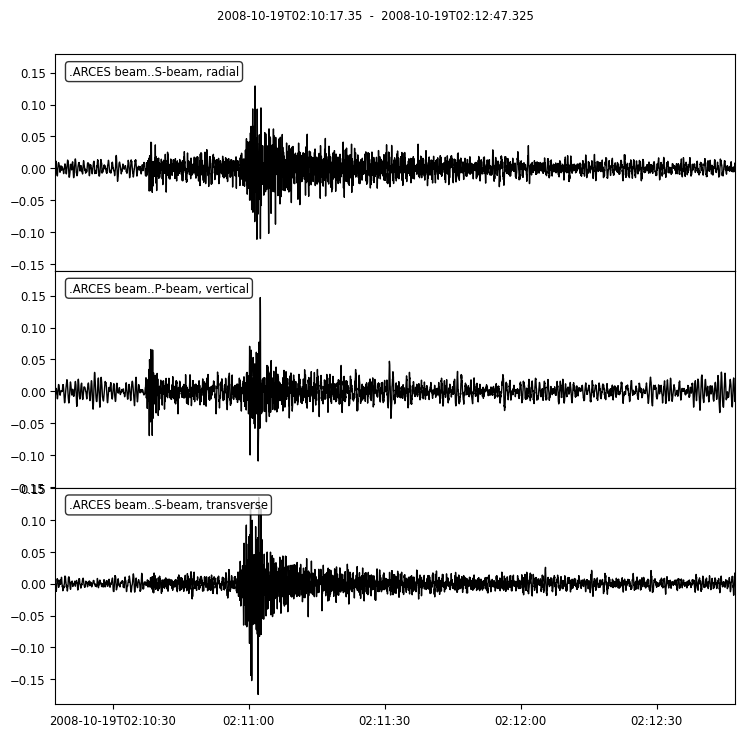

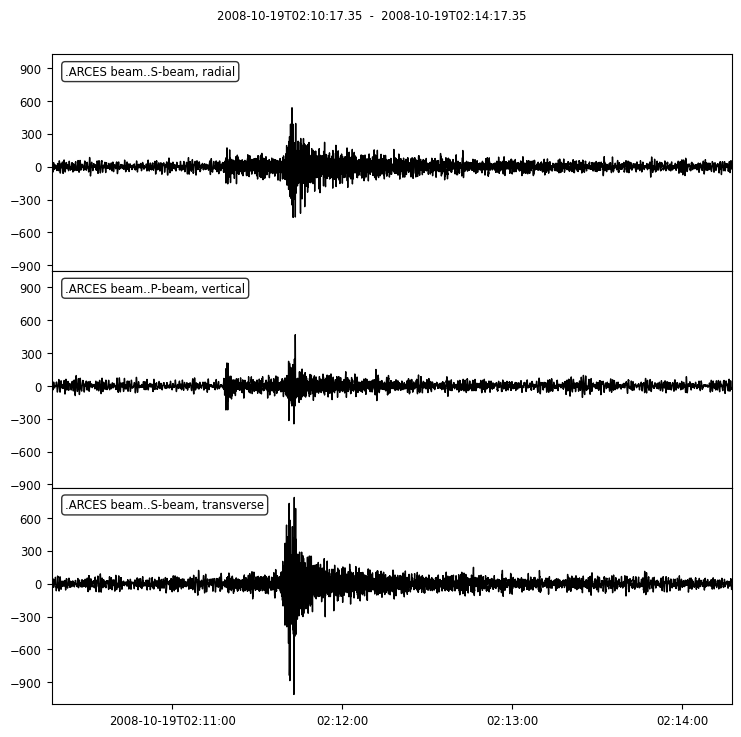

{   'analyst_pick_time': None,
    'az_to_arces': 266.05164944152483,
    'baz_to_arces': 81.900799989676,
    'comments': [   {   'creation_info': {'author': 'general'},
                        'resource_id': 'smi:local/212ac593-a918-49a7-9b50-c28a9738b052',
                        'text': 'PROBABLY EARTHQUAKE, NORTHERN FINNMARK, '
                                'NORWAY'}],
    'dist_to_arces': 173.1520823881156,
    'est_arrivaltime_arces': '2008-10-19 02:11:17.338000',
    'event_type': 'earthquake',
    'event_type_certainty': 'suspected',
    'magnitude_dist_ratio': 0.008085377782878399,
    'magnitude_sqrtdist_ratio': 0.1063932746748109,
    'magnitudes': [   {   'creation_info': {'agency_id': 'HEL'},
                          'mag': 1.4,
                          'mag_errors': {'uncertainty': 0.1},
                          'magnitude_type': 'ML',
                          'origin_id': 'smi:local/c86f54cf-3d26-4929-83fe-7ce35bcc1acd',
                          'resource_id': 's

In [56]:
# Plotting false negative
index = false_negatives[i]
original_trace, sample_info = handler.path_to_trace(val_ds[index][0])
transformed_trace = x_val[index]
print(f"Predicted label: {predictions[index]}, Correct: {y_val[index]}")
print("Transformed")
helper.plot_event(transformed_trace, sample_info)
helper.plot_event(original_trace, sample_info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sample_info)
i += 1

In [57]:
j = 0

Predicted label: [ 0.69473946], Correct: [0]
Transformed


/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


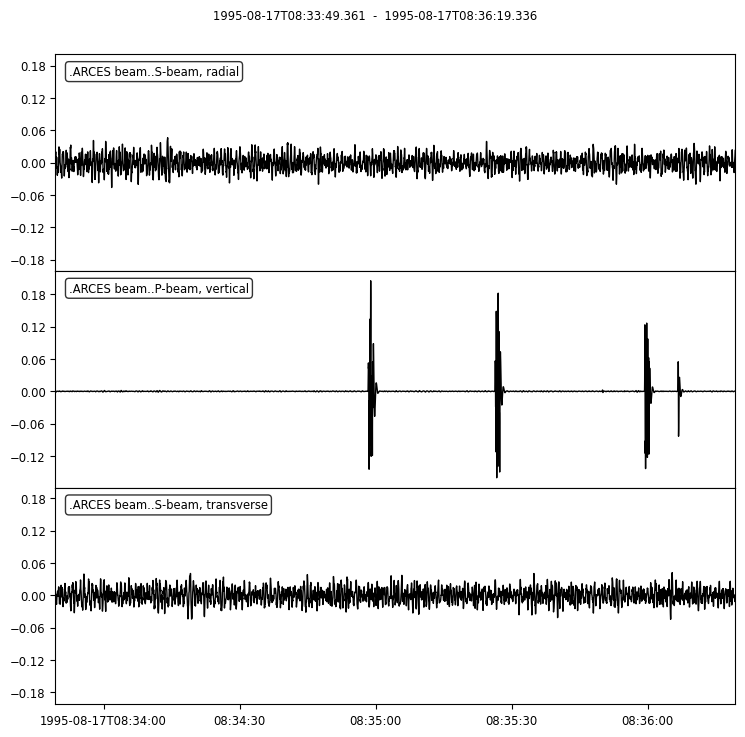

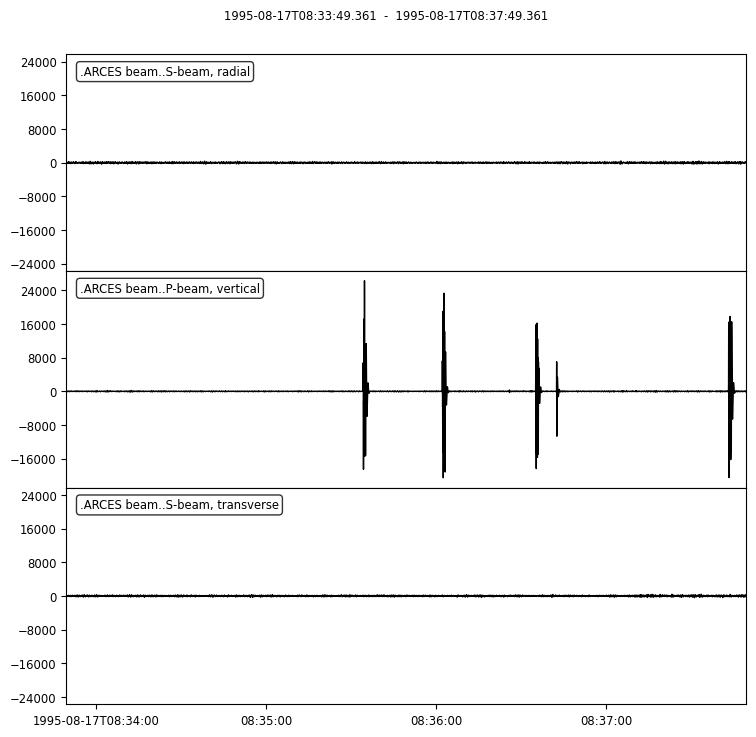

{   'analyst_pick_time': None,
    'az_to_arces': 356.76851544320556,
    'baz_to_arces': 175.30694068406865,
    'dist_to_arces': 1122.8753819338,
    'est_arrivaltime_arces': '1995-08-17 08:34:49.350000',
    'event_type': 'explosion',
    'event_type_certainty': 'known',
    'magnitude_dist_ratio': 0.0020483127843082395,
    'magnitude_sqrtdist_ratio': 0.06863759468329984,
    'magnitudes': [   {   'creation_info': {'agency_id': 'HEL'},
                          'mag': 2.3,
                          'magnitude_type': 'MA',
                          'origin_id': 'smi:local/26353efd-c511-40c0-bb97-183f6bc7c25e',
                          'resource_id': 'smi:local/d535bccf-9bf9-4219-9f47-698ddb31b239',
                          'station_count': 4}],
    'origins': [   {   'creation_info': {'agency_id': 'HEL'},
                       'depth': 0.0,
                       'latitude': 59.481,
                       'latitude_errors': {'uncertainty': 1.2},
                       'longitude'

In [78]:
# Plotting false positives
index = false_positives[j]
original_trace, sample_info = handler.path_to_trace(val_ds[index][0])
transformed_trace = x_val[index]
print(f"Predicted label: {predictions[index]}, Correct: {y_val[index]}")
print("Transformed")
helper.plot_event(transformed_trace, sample_info)
helper.plot_event(original_trace, sample_info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sample_info)
j += 1